In [2]:
import pandas as pd
path = "/content/drive/My Drive/datasets/Cell_Phones_and_Accessories.json"
df = pd.read_json(path)

**Importing Libraries**

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 

import warnings
warnings.filterwarnings('ignore')

In [4]:
df.head()

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None


**Checking null values**

In [5]:
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352624
Reviewer_Name           91
Review                 530
Rev_summ               355
Review_timestamp         0
Useful              698250
Prod_img            742256
dtype: int64

In our dataset, review and rev_summary having null values. We will drop that column having null values

In [6]:
df.dropna(subset=['Review','Rev_summ'], inplace=True)

In [7]:
df.isnull().sum()

Rating                   0
Rev_verify               0
Review_Date              0
IC                       0
Prod_meta           352259
Reviewer_Name           89
Review                   0
Rev_summ                 0
Review_timestamp         0
Useful              697443
Prod_img            741480
dtype: int64

Now we have dropped na values from Review and Rev_summ, no na values are present in that columna

Lets drop the column which are having high null values along with the unnecessary columns

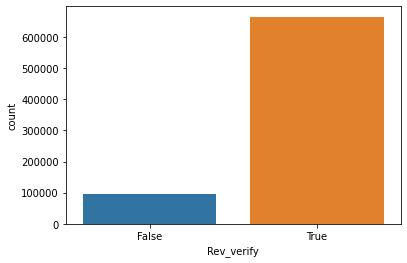

Lets check the count of the Verified and Unverified reviews
True     664660
False     94942
Name: Rev_verify, dtype: int64
Lets check the % of the Verified and Unverified reviews


True     87.501086
False    12.498914
Name: Rev_verify, dtype: float64

In [8]:
#Checking the count of verified reviews

sns.countplot('Rev_verify',data=df)
plt.show()

print('Lets check the count of the Verified and Unverified reviews')
print(df.Rev_verify.value_counts())

print('Lets check the % of the Verified and Unverified reviews')
(df.Rev_verify.value_counts()/len(df.Rev_verify))*100

Here we are having 12% of the reviews which are unverified, we will drop that values at the time of keywords extraction

### Lets find out the min rating, maximum rating and average rating for each product.

In [9]:
#Average Rating

average_ratings = round(df.groupby(['IC'])['Rating'].mean().reset_index(),2)

In [10]:
average_ratings.head()
average_ratings.shape

(48133, 2)

In [11]:
minimum_ratings = df.groupby(['IC'])['Rating'].min().reset_index()

In [12]:
minimum_ratings.head()
minimum_ratings.shape

(48133, 2)

In [13]:
maximum_ratings = df.groupby(['IC'])['Rating'].max().reset_index()

In [14]:
maximum_ratings.head()
maximum_ratings.shape

(48133, 2)

In [15]:
total_ratings = df.groupby(['IC'])['Rating'].count().reset_index()
total_ratings.head()
total_ratings.shape

(48133, 2)

In [16]:
##Getting the unique IC value

unique_ic = df['IC'].unique()

#Creating a data frame from ic values
df_ic = pd.DataFrame(data=unique_ic,columns=['IC'])

In [17]:
#Finding the rating counts for each rating value i.e. 1 2 3 4 5

one_star_rating = round(df[df['Rating']==1].groupby(['IC'])['Rating'].count().reset_index())
two_star_rating = round(df[df['Rating']==2].groupby(['IC'])['Rating'].count().reset_index())
three_star_rating = round(df[df['Rating']==3].groupby(['IC'])['Rating'].count().reset_index())
four_star_rating = round(df[df['Rating']==4].groupby(['IC'])['Rating'].count().reset_index())
five_star_rating = round(df[df['Rating']==5].groupby(['IC'])['Rating'].count().reset_index())

In [18]:
df_indi_rating_count = df_ic.merge(one_star_rating,on='IC',how='left').merge(two_star_rating,how='left',on='IC').merge(three_star_rating,how='left',on='IC').merge(four_star_rating,how='left',on='IC').merge(five_star_rating,how='left',on='IC')

In [19]:
df_indi_rating_count.columns = ['IC','1 star ratings','2 star ratings','3 star ratings','4 star ratings','5 star ratings']

In [20]:
#Replacing all NaN values with 0

df_indi_rating_count = df_indi_rating_count.fillna(0)
df_indi_rating_count.isnull().sum()

IC                0
1 star ratings    0
2 star ratings    0
3 star ratings    0
4 star ratings    0
5 star ratings    0
dtype: int64

In [21]:
##Converting float values to int

for col in df_indi_rating_count.select_dtypes(include=['float']).columns:
  df_indi_rating_count[col] = df_indi_rating_count[col].astype(int)

In [22]:
df_indi_rating_count.sample(10)

,IC,1 star ratings,2 star ratings,3 star ratings,4 star ratings,5 star ratings
37537,B0175PZH5K,0,1,1,1,1
5006,B00YE6WRPW,3,1,2,1,0
24336,B01EJBGCM0,0,0,1,1,2
32101,B009KY49UE,0,0,0,7,6
16872,B00CASNSKO,0,0,0,1,5
28708,B0050WSWIU,1,0,0,0,2
17657,B00VSRTVH2,1,1,1,0,2
46014,B01EO2XT0W,0,1,1,0,1
34028,B00RSMO856,0,0,0,3,4
25866,B0121OJXZK,0,0,0,0,3


In [23]:
df_rating_set = [total_ratings, average_ratings, maximum_ratings, minimum_ratings,df_indi_rating_count]

In [24]:
df_rating_data = functools.reduce(lambda left,right: pd.merge(left,right,on='IC'), df_rating_set)

In [25]:
df_rating_data.columns=['IC','Total rating','Average rating','Maximum rating','Minimum rating','1 star ratings','2 star ratings','3 star ratings','4 star ratings','5 star ratings']

In [26]:
df_rating_data.shape

(48133, 10)

In [27]:
df_rating_data

,IC,Total rating,Average rating,Maximum rating,Minimum rating,1 star ratings,2 star ratings,3 star ratings,4 star ratings,5 star ratings
0,7508492919,40,4.30,5,1,1,1,4,13,21
1,7532385086,7,3.29,5,1,2,0,1,2,2
2,7887421268,13,3.54,5,1,3,1,1,2,6
3,8199900164,4,3.75,5,2,0,1,1,0,2
4,8288853439,11,3.82,5,1,2,1,0,2,6
...,...,...,...,...,...,...,...,...,...,...
48128,B01HJBS5C2,12,3.25,5,1,2,3,1,2,4
48129,B01HJC7N4C,5,4.60,5,3,0,0,1,0,4
48130,B01HJCN1UC,22,4.73,5,4,0,0,0,6,16
48131,B01HJCN55I,11,4.45,5,2,0,2,0,0,9


In [28]:
df_rating_data.to_csv('df_rating_data.csv',index_label=False)

In [29]:
#Droping Rev_verify, Review_date, Prod_meta, Reviewer_Name, Review_timestamp, Useful and Prod_img and Review 

#We will extract our keywords and product summary based on the Rev summary

df_ext = df.loc[:,['IC','Rev_summ']]

In [30]:
#checking for the null values
df_ext.isnull().sum()

IC          0
Rev_summ    0
dtype: int64

In [31]:
df_ext["Rev Length"]= df_ext["Rev_summ"].str.len() 

In [32]:
df_ext.sort_values("IC", inplace = True) 

In [33]:
df_ext.shape

(759602, 3)

In [34]:
#Dropping duplicate values from dataframe

df_ext.drop_duplicates(inplace=True)

In [35]:
df_ext.shape

(608602, 3)

In [36]:
df_ext.nunique()

IC             48133
Rev_summ      366596
Rev Length       153
dtype: int64

In [ ]:
#Here we have dropped 1.5L rows from the data frame which were duplicate

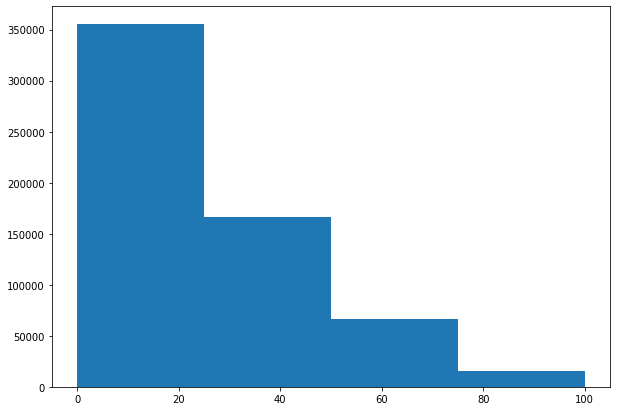

In [47]:
#plotting distribution of string 

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(df_ext['Rev Length'], bins = [0, 25, 50, 75, 100]) 
  
# Show plot 
plt.show() 

In [48]:
#Merging data set review on IC
df_merge = df_ext.groupby(['IC'])['Rev_summ'].apply('. '.join).reset_index()

In [50]:
df_merge.shape

(48133, 2)

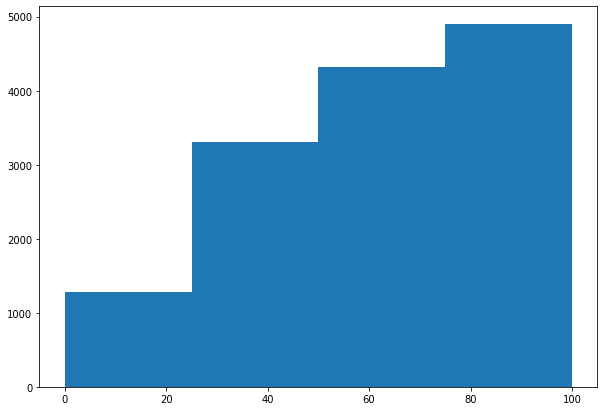

In [54]:
#plotting distribution of string 
df_merge["Rev Length"]= df_merge["Rev_summ"].str.len() 
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.hist(df_merge['Rev Length'], bins = [0, 25, 50, 75, 100]) 
  
# Show plot 
plt.show() 

# **EXTRACTING SUMMARY AND KEYWORDS FROM REVIEW**

In [55]:
df_merge.rename(columns={"IC":'Product_name',"Rev_summ":'prod_des'},inplace=True)

In [56]:
data = df_merge

In [57]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [59]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [60]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
def extract_noun(doc):
  return ([i for i in nlp(doc) if i.pos_=='NOUN'],[i for i in nlp(doc) if i.pos_=='PROPN'])

In [62]:
data['noun_keywords'] =  data['prod_des'].apply(extract_noun)


In [63]:
data.head()

,Product_name,prod_des,Rev Length,noun_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,540,"([case, case, Bing, price, case, case, tightt,..."
1,7532385086,A waste of money!. One Star. htc evo cover. No...,123,"([waste, money, evo, product], [Star, htc, Sta..."
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,190,"([Stars, plastic, suede, deal, case, fit], [St..."
3,8199900164,item didn't work. Five Stars. I,31,"([item, Stars], [])"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,140,"([BUY, Stars, charger, Stars, charger], [Galax..."


In [66]:
df_noun_out = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'keywords':data['noun_keywords']})


In [69]:
df_noun_out.sample(10)


,Product_name,prod_des,keywords
25496,B00O2E0FWS,Tough case for a tough lady.. Five Stars. Good...,"([case, lady, Stars, Coverage, case, case], [C..."
37748,B01541LZNK,Light up from the edges!. Four Stars. Five Sta...,"([edges, Stars, Stars, picture, case, people, ..."
1503,B003M2Y4HS,Broken. Pretty good case for what it is. Exact...,"([case], [kinda])"
2539,B004MHNBN0,Sooooo Cute!!. She loves it !! Thanks. Five St...,"([Thanks, Stars, case, case, Heart, love, cove..."
30283,B00TPG2YQ8,Super good phone. Loving it!. Unexpectedly goo...,"([phone, flaw, Stars, Stars], [])"
35455,B011EJNUE8,very inexpensive and works great. Great value....,"([value, Stars, Stars, cable, job, charm], [St..."
637,B00170I3ME,Worth the price. great product. Waste of money...,"([price, product, Waste, money, Stars], [])"
47151,B01G8MGFF2,"It's no runway model, but it is great at prote...","([runway, model, phone, Stars, Product, piece,..."
29075,B00RZNZJX8,Okay.. ... last update to lollipop my phone's ...,"([update, phone, battery, power, bank, charger..."
15325,B00FQFFSZ6,I like it. Five Stars. Great product. Melody,"([Stars, product, Melody], [])"


In [70]:
def tuple_to_list(t):
  l1,l2 = t
  l1.extend(l2)
  return [str(i) for i in l1]

In [71]:
data['keywords'] = df_noun_out['keywords'].apply(tuple_to_list)


In [72]:
data['keywords']


0        [case, case, Bing, price, case, case, tightt, ...
1           [waste, money, evo, product, Star, htc, Stars]
2        [Stars, plastic, suede, deal, case, fit, Star,...
3                                            [item, Stars]
4        [BUY, Stars, charger, Stars, charger, Galaxy, ...
                               ...                        
48128    [headphone, holes, case, holster, case, needs,...
48129    [experience, one, headset, device, family, fun...
48130    [Stars, product, nylon, cord, cable, thanks, c...
48131                    [cable, cable, Stars, Stars, Buy]
48132           [crack, Stars, cover, folks, money, price]
Name: keywords, Length: 48133, dtype: object

In [73]:
df = [' '.join(i) for i in data['keywords']]


In [74]:
vectorizer1 = TfidfVectorizer(df,lowercase = True, analyzer='word', stop_words='english', min_df = 0.1,max_df = 0.9)
tfidfmat1 = vectorizer1.fit_transform(df)
print("TFIDF shape: ", tfidfmat1.shape)
print("Terms in TFIDF: ",vectorizer1.get_feature_names())
terms = vectorizer1.get_feature_names()

TFIDF shape:  (48133, 11)
Terms in TFIDF:  ['case', 'fit', 'iphone', 'phone', 'price', 'product', 'protection', 'quality', 'screen', 'star', 'stars']


In [75]:
def topn(tfidfmat,n):
  lst = []
  lst = [tfidfmat.todense()[i].argsort()[:,-n:] for i in range(tfidfmat.shape[0])]
  return lst

In [76]:

def get_topn_multi_keywords(tfidfmat,n,terms):
  topn_lst_indices = topn(tfidfmat,n)
  topn_lst_indices = np.array(topn_lst_indices).reshape((tfidfmat.shape[0],n))
  doc_keywords = [[terms[i] for i in l] for l in topn_lst_indices]
  return doc_keywords

In [77]:
doc_keywords = get_topn_multi_keywords(tfidfmat1,3,terms)
df_tfidf_out1 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'multi_keywords':doc_keywords})
df_tfidf_out1

,Product_name,prod_des,multi_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[iphone, phone, case]"
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[stars, product, star]"
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[stars, star, fit]"
3,8199900164,item didn't work. Five Stars. I,"[screen, star, stars]"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[screen, star, stars]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[stars, star, case]"
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[screen, star, stars]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[star, product, stars]"
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[screen, star, stars]"


In [78]:
def preprocessing(s):
  s = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','',s)
  s = re.sub(r"http\S+",'', s)  
  d = nlp(s)
  lemmas = [token.lemma_ for token in d if not token.is_stop]
  return lemmas

In [79]:
pre_df = [preprocessing(i) for i in df]


In [80]:
pre_df[0]


['case',
 'case',
 'Bing',
 'price',
 'case',
 'case',
 'tightt',
 'plastic',
 'phone',
 'cover',
 'ADORABLE',
 'REST',
 'Bling',
 'bow',
 'case',
 'case',
 'Great',
 'Gift',
 'Luv',
 'luv',
 'luv',
 'iPhone',
 'BEAUTIFUL',
 'ble',
 'PHONE',
 'CASE',
 'star',
 'GONNA',
 'sara',
 'Cute',
 'Crystal',
 'Bow']

In [81]:
docs = [' '.join(i) for i in pre_df]

In [82]:
vectorizer2 = TfidfVectorizer(docs,lowercase = True, min_df = 0.05,max_df = 0.95)
tfidfmat2 = vectorizer2.fit_transform(docs)
tfidfmat2.shape

(48133, 30)

In [83]:
vectorizer2.get_feature_names()[:5]


['battery', 'buy', 'case', 'charge', 'charger']

In [84]:
max_ind = [np.argmax(i) for i in tfidfmat2.todense()]
terms2 = vectorizer2.get_feature_names()
doc_keywords = [terms2[i] for i in max_ind]
df_tfidf_out2 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'keywords':doc_keywords})
df_tfidf_out2

,Product_name,prod_des,keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,case
1,7532385086,A waste of money!. One Star. htc evo cover. No...,money
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,protector
3,8199900164,item didn't work. Five Stars. I,item
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,charger
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,phone
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...",stars
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,star
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,buy


In [85]:
doc_keywords = get_topn_multi_keywords(tfidfmat2,3,terms2)
df_tfidf_out2 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'multi_keywords':doc_keywords})
df_tfidf_out2

,Product_name,prod_des,multi_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[cover, phone, case]"
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[product, star, money]"
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[star, fit, protector]"
3,8199900164,item didn't work. Five Stars. I,"[work, star, item]"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[buy, galaxy, charger]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[stars, case, phone]"
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[job, work, stars]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[work, product, star]"
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[star, stars, buy]"


In [86]:
vectorizer3 = TfidfVectorizer(docs,lowercase = True, min_df = 0.1,max_df = 0.9)
tfidfmat3 = vectorizer3.fit_transform(docs)
tfidfmat3.shape

(48133, 11)

In [87]:
max_ind = [np.argmax(i) for i in tfidfmat3.todense()]
terms3 = vectorizer3.get_feature_names()
doc_keywords = [terms3[i] for i in max_ind]
df_tfidf_out3 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'keywords':doc_keywords})
df_tfidf_out3

,Product_name,prod_des,keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,case
1,7532385086,A waste of money!. One Star. htc evo cover. No...,star
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,fit
3,8199900164,item didn't work. Five Stars. I,star
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,star
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,phone
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...",stars
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,star
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,stars


In [88]:
doc_multi_keywords = get_topn_multi_keywords(tfidfmat3,3,terms3)
df_tfidf_out3 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'keywords':doc_multi_keywords})
df_tfidf_out3

,Product_name,prod_des,keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[iphone, phone, case]"
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[stars, product, star]"
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[case, star, fit]"
3,8199900164,item didn't work. Five Stars. I,"[screen, stars, star]"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[screen, stars, star]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[stars, case, phone]"
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[screen, star, stars]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[stars, product, star]"
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[screen, star, stars]"


In [89]:

vectorizer4 = TfidfVectorizer(docs,lowercase = True, min_df = 0.05,max_df = 0.95,ngram_range=(1,2))
tfidfmat4 = vectorizer4.fit_transform(docs)
tfidfmat4.shape

(48133, 40)

In [90]:
terms4 =  vectorizer4.get_feature_names()
doc_multi_keywords4 = get_topn_multi_keywords(tfidfmat4,3,terms4)

In [91]:
terms4[:10]


['battery',
 'buy',
 'case',
 'case case',
 'case phone',
 'case star',
 'case stars',
 'charge',
 'charger',
 'color']

In [92]:
df_tfidf_multi_out4 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'multi_keywords':doc_multi_keywords4})
df_tfidf_multi_out4

,Product_name,prod_des,multi_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[phone, case case, case]"
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[product, star, money]"
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[star, fit, protector]"
3,8199900164,item didn't work. Five Stars. I,"[work, star, item]"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[buy, galaxy, charger]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[case, stars star, phone]"
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[color, work, stars]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[work, product, star]"
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[star, stars, buy]"


In [93]:

vectorizer5 = TfidfVectorizer(docs,lowercase = True, min_df = 0.02,max_df = 0.95,ngram_range=(1,2))
tfidfmat5 = vectorizer5.fit_transform(docs)
tfidfmat5.shape

(48133, 123)

In [94]:

terms5 =  vectorizer5.get_feature_names()
doc_multi_keywords5 = get_topn_multi_keywords(tfidfmat5,3,terms5)

In [95]:
df_tfidf_multi_out5 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'multi_keywords':doc_multi_keywords5})
df_tfidf_multi_out5

,Product_name,prod_des,multi_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[gift, case case, case]"
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[money, product star, waste]"
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[star stars, plastic, case fit]"
3,8199900164,item didn't work. Five Stars. I,"[year, star, item]"
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[buy, galaxy, charger]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[phone phone, piece, clip]"
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[year, stars, device]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[star product, cord, cable]"
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[buy, star stars, cable]"


In [96]:

def get_tuned_keywords(docs,min_df,max_df,ngram_range,no_of_keywords):
  vectorizer5 = TfidfVectorizer(docs,lowercase = True, min_df =min_df,max_df = max_df,ngram_range=ngram_range)
  tfidfmat5 = vectorizer5.fit_transform(docs)
  print("Tfidf shape:",tfidfmat5.shape)
  terms5 =  vectorizer5.get_feature_names()
  print(terms5)
  doc_multi_keywords5 = get_topn_multi_keywords(tfidfmat5,no_of_keywords,terms5)
  df_tfidf_multi_out5 = pd.DataFrame(data = {'Product_name': data['Product_name'],'prod_des':data['prod_des'],'multi_keywords':doc_multi_keywords5})
  return(df_tfidf_multi_out5)

In [97]:
final_out_task1_df = get_tuned_keywords(docs,0.02,0.95,(1,3),7)
final_out_task1_df

Tfidf shape: (48133, 126)
['apple', 'awesome', 'battery', 'bit', 'brand', 'button', 'buy', 'cable', 'car', 'card', 'case', 'case case', 'case case case', 'case color', 'case fit', 'case phone', 'case phone case', 'case price', 'case product', 'case protection', 'case quality', 'case star', 'case stars', 'cell', 'cell phone', 'charge', 'charger', 'clip', 'color', 'cord', 'cover', 'customer', 'customer service', 'day', 'deal', 'design', 'device', 'edge', 'excellent', 'fit', 'galaxy', 'gift', 'glass', 'good', 'great', 'grip', 'hand', 'holder', 'idea', 'iphone', 'issue', 'item', 'job', 'junk', 'leather', 'lg', 'life', 'look', 'lot', 'love', 'material', 'money', 'month', 'mount', 'nice', 'note', 'otterbox', 'perfect', 'phone', 'phone case', 'phone case case', 'phone phone', 'phone star', 'phone stars', 'picture', 'piece', 'plastic', 'port', 'power', 'price', 'price case', 'price star', 'problem', 'product', 'product case', 'product price', 'product star', 'protection', 'protection case', 'p

,Product_name,prod_des,multi_keywords
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[case star, phone, price case, plastic, gift, ..."
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[glass, excellent, product, star, money, produ..."
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[star, fit, protector, deal, star stars, plast..."
3,8199900164,item didn't work. Five Stars. I,"[deal, day, customer service, great, year, sta..."
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[fit, year, stars, star, buy, galaxy, charger]"
...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[case, stars star, month, phone, phone phone, ..."
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[design, deal, day, customer service, cover, s..."
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[deal, day, product, star, star product, cord,..."
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[good, fit, star, stars, buy, star stars, cable]"


In [99]:
final_out_task1_df.to_csv('final_out_task1_df.csv',index=False)

In [101]:

i=48130
print("Original PDP:\n",data['prod_des'][i])
print("After POS:\n",docs[i])
print("Final Keywords:\n",final_out_task1_df['multi_keywords'][i])

Original PDP:
 Four Stars. Five Stars. Durable and well made. Decent!. Good product. Highly recommend!. but the nylon makes it less flexible than I would have liked.. It Works. It Really Works.. Pretty blue cord. Nice thick cable. thanks for a great cord.... very long cable cord. Keeps my electronics ready for action.. Best of the Best. The cable is perfect. It showed up as promised and is exactly .... Good cable great length.
After POS:
 star product nylon cord cable thank cord cable cord electronics action cable cable length star
Final Keywords:
 ['deal', 'day', 'product', 'star', 'star product', 'cord', 'cable']


In [ ]:
i = 2222
print("Original PDP:\n",data['prod_des'][i]+"\n")
doc = nlp(data['prod_des'][i])
for chunk in doc.noun_chunks:
    print("ct:"+chunk.text+"\ncrt:"+ chunk.root.text+"\ncrd:"+ chunk.root.dep_+
            "\ncrh:"+chunk.root.head.text+"\n\n")

In [104]:
chunk_text = [i.text.lower() for i in doc.noun_chunks]
chunk_root_text = [i.root.text.lower() for i in doc.noun_chunks]
print(chunk_text)
print(chunk_root_text)
l = chunk_text
lst_kw = final_out_task1_df['multi_keywords'][1]
print(lst_kw)

['gooey film', 'removal', 'a great screen protector', 'bubble', 'i', 'i', 'my phone', 'bubbles', 'best screen protector']
['film', 'removal', 'protector', 'bubble', 'i', 'i', 'phone', 'bubbles', 'protector']
['glass', 'excellent', 'product', 'star', 'money', 'product star', 'waste']


In [106]:
def match(lst_kw,lst_crt_ct):
  l = []
  for i in lst_kw:
    for j in lst_crt_ct:
      if i in j.split():
        #print(i,":",j)
        l.append(j)
  return list(set(l))

In [107]:

prod_des_lst = [i for i in final_out_task1_df['prod_des']]
def extract_ksp(col1,col2):
  lst_keywords = col1
  prod_des = col2
  doc = nlp(prod_des)
  lst_chunk_text = [i.text.lower() for i in doc.noun_chunks]
  lst_chunk_text.extend([i.root.text.lower() for i in doc.noun_chunks])
  return(match(lst_keywords,lst_chunk_text))

In [108]:
out = final_out_task1_df.apply(lambda x: extract_ksp(x.multi_keywords,x.prod_des),axis = 1)


In [128]:
df_ksp= pd.DataFrame(data = {'IC': data['Product_name'],'Rev_summ':data['prod_des'],'keywords':final_out_task1_df['multi_keywords'],'summary':out})
df_ksp.to_csv('final_out.csv',index=False)

In [129]:
df_ksp

,IC,Rev_summ,keywords,summary
0,7508492919,Cute. I can't stop using this case!. Bling cut...,"[case star, phone, price case, plastic, gift, ...","[plastic, the same case, great gift, 4s phone ..."
1,7532385086,A waste of money!. One Star. htc evo cover. No...,"[glass, excellent, product, star, money, produ...","[product, money, this product, star, waste, a ..."
2,7887421268,Five Stars. plastic with suede. good deal. Thi...,"[star, fit, protector, deal, star stars, plast...","[protector, plastic, fit, star, simple and att..."
3,8199900164,item didn't work. Five Stars. I,"[deal, day, customer service, great, year, sta...",[item]
4,8288853439,Galaxy S4 Charger. Works Great.... GOOD BUY. L...,"[fit, year, stars, star, buy, galaxy, charger]","[buy, four stars, charger, stars, galaxy s4 ch..."
...,...,...,...,...
48128,B01HJBS5C2,(Hybrid Carbon Fiber) Charger and headphone ho...,"[case, stars star, month, phone, phone phone, ...","[phone, clip, case, a good solid 2 piece cover..."
48129,B01HJC7N4C,"My first experience with VR, and it's a very p...","[design, deal, day, customer service, cover, s...","[this device, three stars, device, stars]"
48130,B01HJCN1UC,Four Stars. Five Stars. Durable and well made....,"[deal, day, product, star, star product, cord,...","[product, the cable, good cable great length, ..."
48131,B01HJCN55I,I really like the cable. Good cable. Worth.. G...,"[good, fit, star, stars, buy, star stars, cable]","[buy, the cable, stars, great buy, cable, two ..."


In [130]:

df_ksp.to_csv('df_ksp.csv',index=False)

In [131]:
len(df_ksp)

48133

In [143]:
import random
n = np.random.randint(0, len(df_ksp), 1)
i =45793 # n[0]
print("Product_name\n",df_ksp['IC'][i])
print("Original PDP:\n",df_ksp['Rev_summ'][i])
print("After POS:\n",docs[i])
print("Apppropriate Keywords:\n",df_ksp['keywords'][i])
print("Summary:\n",df_ksp['summary'][i])

Product_name
 B01EMY6G2U
Original PDP:
 Works and doesnt damage the mask.. Fits my 1st generation Gear VR. Total false advertising..too small. Definitely a keeper
After POS:
 Works mask generation advertising keeper Gear VR
Apppropriate Keywords:
 ['device', 'design', 'deal', 'day', 'customer service', 'customer', 'works']
Summary:
 ['works']


In [137]:
print(df_ksp.shape)
print(df_rating_data.shape)

(48133, 4)
(48133, 10)


In [138]:
df_final = df_ksp.merge(df_rating_data,on='IC',how='inner')

In [140]:
df_final.sample(10)

,IC,Rev_summ,keywords,summary,Total rating,Average rating,Maximum rating,Minimum rating,1 star ratings,2 star ratings,3 star ratings,4 star ratings,5 star ratings
40675,B018GTIPLC,Works great !!. Not good. I have a 2013 Nexus ...,"[works, cable, day, phone phone, port, price, ...","[price, nice charger, port, works, charger, ba...",27,4.19,5,1,4,0,2,2,19
45793,B01EMY6G2U,Works and doesnt damage the mask.. Fits my 1st...,"[device, design, deal, day, customer service, ...",[works],4,3.75,5,1,1,0,0,1,2
46483,B01FHSKVNK,"Very thin braided cable, died within a week. B...","[product price, car, week, charger, quality, u...","[car, type-c usb cable, nice cable, charger, g...",30,4.00,5,1,5,1,1,5,18
17760,B00I4EJWL2,What do you expect for under $5 buckaroos. Fiv...,"[galaxy, gift, edge, star, screen, protector, ...",[better screen protectors],3,3.00,5,1,1,0,1,0,1
37302,B014J4LACO,Shaky at times.. The case is very bulky and th...,"[day, star, case, screen, cover, time, car]","[the case, case, the screen cover, cover]",8,2.75,5,1,2,1,3,1,1
36206,B01328RFH2,One Star. Cheaply made. Breaks too easy.. Nice...,"[value, stars star, charge, month, cable, usb,...","[the usb cable, great replacement, replacement...",9,3.22,5,1,3,0,1,2,3
3066,B0050MW0Z6,GVanHorn. Five Stars. Ipod working again. Four...,"[design, deal, day, customer service, grip, st...","[four stars, stars, five stars]",5,4.00,5,1,1,0,0,1,3
5604,B006XGIM78,Any Idea. I recommend this for anyone that has...,"[great, galaxy, case, phone, iphone, phone cas...","[phone, a case, idea, case, an iphone, a phone...",4,3.25,5,1,1,0,1,1,1
15750,B00G8SQLQA,Five Stars. Excellent.. i wear this phone case...,"[deal, day, star, case, phone, phone case, sta...",[this phone case alot],8,4.00,5,1,2,0,0,0,6
2829,B004WOT3FI,Poor Quality. i enjoy this headsets. I talked ...,"[product, button, customer service, quality pr...","[product, good product, quality, star, seller,...",32,3.97,5,1,3,1,4,10,14


In [141]:
df_final.to_json('Customer_review_summarization.json')